In [ ]:
import matplotlib.pyplot as plt
import torch
from diffdrr.drr import DRR
from diffdrr.visualization import plot_drr

from diffpose.deepfluoro import DeepFluoroDataset, Transforms
from diffpose.registration import SparseRegistration, vector_to_img

In [ ]:
specimen = DeepFluoroDataset(1)
height = 256
subsample = (1536 - 100) / height
delx = 0.194 * subsample

_, pose = specimen[0]
pose = pose.cuda()

drr = DRR(
    specimen.volume,
    specimen.spacing,
    sdr=specimen.focal_len / 2,
    height=height,
    delx=delx,
    x0=specimen.x0,
    y0=specimen.y0,
    reverse_x_axis=True,
    bone_attenuation_multiplier=2.5,
).to("cuda")

registration = SparseRegistration(drr, pose, parameterization="se3_log_map")

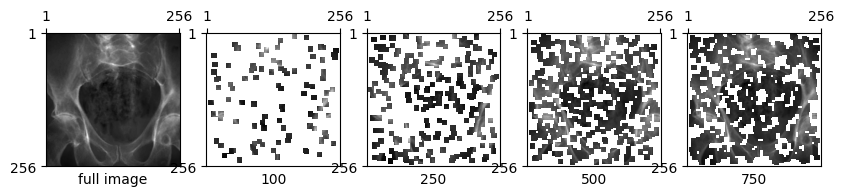

In [ ]:
# Generate images with different numbers of patches
imgs = []
n_patches = [None, 100, 250, 500, 750]
for n in n_patches:
    img, mask = registration(n, patch_size=13)
    if n is not None:
        img = vector_to_img(img, mask)
    imgs.append(img)

# Plot the images with various levels of sparsity
axs = plot_drr(torch.concat(imgs))
for ax, n in zip(axs, n_patches):
    if n is None:
        n = "full image"
    ax.set(xlabel=n)
plt.show()

In [ ]:
# Full image with SparseRegistration
%timeit -n 10 -r 100 registration(n_patches=None, patch_size=13)

29.5 ms ± 375 µs per loop (mean ± std. dev. of 100 runs, 10 loops each)


In [ ]:
# 100 patches
%timeit -n 10 -r 100 registration(n_patches=100, patch_size=13)

8.57 ms ± 51.3 µs per loop (mean ± std. dev. of 100 runs, 10 loops each)


In [ ]:
# 250 patches
%timeit -n 10 -r 100 registration(n_patches=250, patch_size=13)

15.3 ms ± 112 µs per loop (mean ± std. dev. of 100 runs, 10 loops each)


In [ ]:
# 500 patches
%timeit -n 10 -r 100 registration(n_patches=500, patch_size=13)

22.1 ms ± 141 µs per loop (mean ± std. dev. of 100 runs, 10 loops each)


In [ ]:
# 750 patches
%timeit -n 10 -r 100 registration(n_patches=750, patch_size=13)

25.7 ms ± 157 µs per loop (mean ± std. dev. of 100 runs, 10 loops each)


In [ ]:
# Full image with DiffDRR
%timeit -n 10 -r 100 drr(None, None, None, pose=pose)

29.7 ms ± 203 µs per loop (mean ± std. dev. of 100 runs, 10 loops each)


In [ ]:
from diffdrr.metrics import MultiscaleNormalizedCrossCorrelation2d

from diffpose.registration import VectorizedNormalizedCrossCorrelation2d

In [ ]:
mncc = MultiscaleNormalizedCrossCorrelation2d(patch_sizes=[None, 13], patch_weights=[0.5, 0.5])
smncc = VectorizedNormalizedCrossCorrelation2d()

In [ ]:
%timeit mncc(img, img)

1.51 ms ± 1.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
pred_img, mask = registration(n_patches=1000, patch_size=13)

In [ ]:
%timeit smncc(img, pred_img, mask, n_patches=1000, patch_size=13)

3.27 ms ± 8.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
img.shape

torch.Size([1, 1, 256, 256])

In [ ]:
pred_img.shape

torch.Size([1, 14675])

In [ ]:
1 / 30e-3

33.333333333333336

In [ ]:
1/ ((30+1.5) * 1e-3)

31.746031746031747